# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [21]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

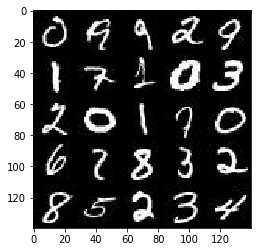

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

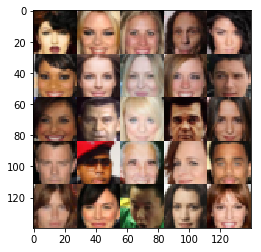

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [25]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input');
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [26]:
def leak_relu(x, multiplier=0.1):
    '''
    x: Tensor
    multiplier: leak multiplier 
    
    Returns max tensor on input tensor. 
    '''
    return tf.maximum(x, x * multiplier)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [27]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Image size is 28x28x(1 - MNIST, 3 - celeb)
        layer = tf.layers.conv2d(images, 
                                 64, 
                                 3, 
                                 strides=2, 
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer = leak_relu(layer)
        layer = tf.layers.dropout(layer, rate=0.9)
        
        
        # Image 7x7x128 
        layer = tf.layers.conv2d(layer, 
                                 128, 
                                 3, 
                                 strides=2, 
                                 padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = leak_relu(layer)
        layer = tf.layers.dropout(layer, rate=0.9)
        

        # Image 4x4x25
        layer = tf.layers.conv2d(layer, 
                                 256, 
                                 3, 
                                 strides=2,
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = leak_relu(layer)
        layer = tf.layers.dropout(layer, rate=0.9)
        

        flat = tf.reshape(layer, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train = True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not is_train):
        
        # Image 7x7x1024
        layer = tf.layers.dense(z, 7*7*1024)
        layer = tf.reshape(layer, (-1, 7, 7, 1024))
        layer = tf.layers.batch_normalization(layer, training = is_train)
        layer = tf.nn.relu(layer)
        
        # Image 14x14x512
        layer = tf.layers.conv2d_transpose(layer, 512, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training = is_train)
        relu = tf.nn.relu(layer)
         
        # Image 28x28x256
        layer = tf.layers.conv2d_transpose(layer, 256, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training = is_train)
        layer = tf.nn.relu(layer)

        layer = tf.layers.conv2d_transpose(layer, out_channel_dim, 3, strides=2, padding='same')
        layer = tf.image.resize_images(layer, size=(28, 28)) 
        
        output = tf.nn.tanh(layer, name='generator_main')
        
    return output
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim, is_train = True)
    
    discriminator_real_model, discriminator_real_logits = discriminator(input_real, reuse=False)
    discriminator_fake_model, discriminator_fake_logits = discriminator(generator_model, reuse=True)
    
    smooth = 0.1
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits,
                                                                         labels=tf.ones_like(discriminator_real_model) * (1 - smooth)))
    
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, 
                                                                         labels=tf.zeros_like(discriminator_fake_model)))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, 
                                                                    labels = tf.ones_like(discriminator_fake_model)))
    
    return discriminator_loss, generator_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    training_vars = tf.trainable_variables()
    discriminator_vars = [var for var in training_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in training_vars if var.name.startswith('generator')]
    
 
    discriminator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = discriminator_vars)
    
    deps = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_dep = [dep for dep in deps if dep.name.startswith("generator")]
    
    with tf.control_dependencies(generator_dep):
        generator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = generator_vars)
    
    return discriminator_opt, generator_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    d_ops, g_ops = model_opt(d_loss, g_loss, lr, beta1)
    
    batch = 0;
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch += 1

                # since discriminator expects values from -1 to 1  
                batch_images = 2 * batch_images
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                sess.run(g_ops, feed_dict = {
                    lr :learning_rate,
                    z_input : batch_z,
                })
                
                sess.run(d_ops, feed_dict = {
                    lr : learning_rate,
                    real_input : batch_images, 
                    z_input : batch_z
                })
                
                
                if batch % 10 == 0:
                    # run losses. 
                    train_loss_d = sess.run(d_loss, feed_dict = { real_input : batch_images, z_input : batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict =  { z_input : batch_z})
                    print("Epoch {}/{}... Step {}...".format(epoch_i+1, epochs, batch),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    
                if batch % 100 == 0:
                    print("Sample Outputs....")
                    show_generator_output(sess, 10, z_input, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10... Discriminator Loss: 1.1622... Generator Loss: 0.9058
Epoch 1/2... Step 20... Discriminator Loss: 0.9276... Generator Loss: 1.4265
Epoch 1/2... Step 30... Discriminator Loss: 1.0887... Generator Loss: 1.2619
Epoch 1/2... Step 40... Discriminator Loss: 1.1560... Generator Loss: 1.1534
Epoch 1/2... Step 50... Discriminator Loss: 1.3902... Generator Loss: 1.0875
Epoch 1/2... Step 60... Discriminator Loss: 1.4985... Generator Loss: 0.8645
Epoch 1/2... Step 70... Discriminator Loss: 1.4925... Generator Loss: 0.8040
Epoch 1/2... Step 80... Discriminator Loss: 1.4870... Generator Loss: 0.8505
Epoch 1/2... Step 90... Discriminator Loss: 1.4948... Generator Loss: 0.7017
Epoch 1/2... Step 100... Discriminator Loss: 1.4769... Generator Loss: 0.7714
Sample Outputs....


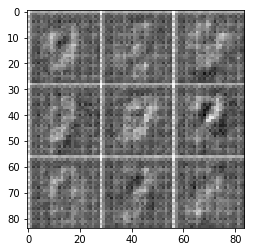

Epoch 1/2... Step 110... Discriminator Loss: 1.4123... Generator Loss: 0.8564
Epoch 1/2... Step 120... Discriminator Loss: 1.3903... Generator Loss: 0.8025
Epoch 1/2... Step 130... Discriminator Loss: 1.3687... Generator Loss: 0.9526
Epoch 1/2... Step 140... Discriminator Loss: 1.3244... Generator Loss: 0.8107
Epoch 1/2... Step 150... Discriminator Loss: 1.3263... Generator Loss: 0.7832
Epoch 1/2... Step 160... Discriminator Loss: 1.3266... Generator Loss: 0.8825
Epoch 1/2... Step 170... Discriminator Loss: 1.2930... Generator Loss: 0.8031
Epoch 1/2... Step 180... Discriminator Loss: 1.2715... Generator Loss: 0.8977
Epoch 1/2... Step 190... Discriminator Loss: 1.2545... Generator Loss: 1.0772
Epoch 1/2... Step 200... Discriminator Loss: 1.2141... Generator Loss: 1.0233
Sample Outputs....


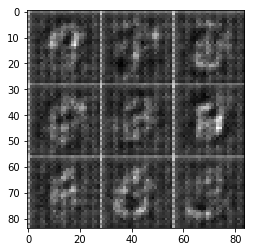

Epoch 1/2... Step 210... Discriminator Loss: 1.1835... Generator Loss: 1.3140
Epoch 1/2... Step 220... Discriminator Loss: 1.2979... Generator Loss: 0.7705
Epoch 1/2... Step 230... Discriminator Loss: 1.2519... Generator Loss: 1.0317
Epoch 1/2... Step 240... Discriminator Loss: 1.2171... Generator Loss: 0.8688
Epoch 1/2... Step 250... Discriminator Loss: 1.1404... Generator Loss: 0.9773
Epoch 1/2... Step 260... Discriminator Loss: 1.2002... Generator Loss: 0.8513
Epoch 1/2... Step 270... Discriminator Loss: 1.1693... Generator Loss: 1.2792
Epoch 1/2... Step 280... Discriminator Loss: 1.1888... Generator Loss: 0.8257
Epoch 1/2... Step 290... Discriminator Loss: 1.1077... Generator Loss: 0.9844
Epoch 1/2... Step 300... Discriminator Loss: 1.1232... Generator Loss: 0.8820
Sample Outputs....


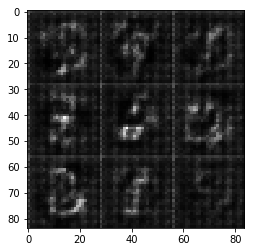

Epoch 1/2... Step 310... Discriminator Loss: 1.0835... Generator Loss: 1.0318
Epoch 1/2... Step 320... Discriminator Loss: 1.1562... Generator Loss: 1.6421
Epoch 1/2... Step 330... Discriminator Loss: 1.0833... Generator Loss: 1.2115
Epoch 1/2... Step 340... Discriminator Loss: 1.0389... Generator Loss: 1.0134
Epoch 1/2... Step 350... Discriminator Loss: 1.0158... Generator Loss: 1.2020
Epoch 1/2... Step 360... Discriminator Loss: 1.0929... Generator Loss: 0.8102
Epoch 1/2... Step 370... Discriminator Loss: 1.0647... Generator Loss: 1.4020
Epoch 1/2... Step 380... Discriminator Loss: 1.0822... Generator Loss: 1.7173
Epoch 1/2... Step 390... Discriminator Loss: 1.0628... Generator Loss: 1.2752
Epoch 1/2... Step 400... Discriminator Loss: 1.0466... Generator Loss: 0.9340
Sample Outputs....


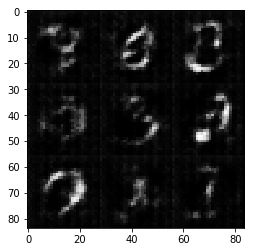

Epoch 1/2... Step 410... Discriminator Loss: 0.9772... Generator Loss: 1.1624
Epoch 1/2... Step 420... Discriminator Loss: 1.0225... Generator Loss: 1.3247
Epoch 1/2... Step 430... Discriminator Loss: 1.0676... Generator Loss: 0.8424
Epoch 1/2... Step 440... Discriminator Loss: 1.0205... Generator Loss: 0.9761
Epoch 1/2... Step 450... Discriminator Loss: 0.9627... Generator Loss: 1.1302
Epoch 1/2... Step 460... Discriminator Loss: 1.0690... Generator Loss: 0.8062
Epoch 1/2... Step 470... Discriminator Loss: 1.0166... Generator Loss: 1.5969
Epoch 1/2... Step 480... Discriminator Loss: 0.9874... Generator Loss: 1.1954
Epoch 1/2... Step 490... Discriminator Loss: 0.9844... Generator Loss: 0.9540
Epoch 1/2... Step 500... Discriminator Loss: 1.0291... Generator Loss: 1.2271
Sample Outputs....


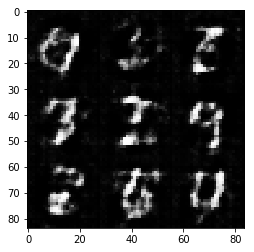

Epoch 1/2... Step 510... Discriminator Loss: 0.9751... Generator Loss: 1.7223
Epoch 1/2... Step 520... Discriminator Loss: 1.0195... Generator Loss: 2.0311
Epoch 1/2... Step 530... Discriminator Loss: 1.1427... Generator Loss: 0.7102
Epoch 1/2... Step 540... Discriminator Loss: 0.9185... Generator Loss: 1.5396
Epoch 1/2... Step 550... Discriminator Loss: 0.9735... Generator Loss: 1.6093
Epoch 1/2... Step 560... Discriminator Loss: 1.0845... Generator Loss: 1.3982
Epoch 1/2... Step 570... Discriminator Loss: 1.0243... Generator Loss: 1.4821
Epoch 1/2... Step 580... Discriminator Loss: 1.0291... Generator Loss: 1.4672
Epoch 1/2... Step 590... Discriminator Loss: 1.1976... Generator Loss: 0.7104
Epoch 1/2... Step 600... Discriminator Loss: 1.1271... Generator Loss: 0.8850
Sample Outputs....


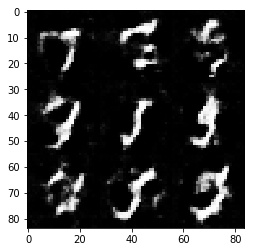

Epoch 1/2... Step 610... Discriminator Loss: 1.1233... Generator Loss: 1.4711
Epoch 1/2... Step 620... Discriminator Loss: 1.0166... Generator Loss: 1.0935
Epoch 1/2... Step 630... Discriminator Loss: 1.1790... Generator Loss: 1.6791
Epoch 1/2... Step 640... Discriminator Loss: 1.0878... Generator Loss: 0.9329
Epoch 1/2... Step 650... Discriminator Loss: 1.0802... Generator Loss: 0.9572
Epoch 1/2... Step 660... Discriminator Loss: 1.0805... Generator Loss: 1.5145
Epoch 1/2... Step 670... Discriminator Loss: 1.0610... Generator Loss: 1.1236
Epoch 1/2... Step 680... Discriminator Loss: 1.3210... Generator Loss: 0.6380
Epoch 1/2... Step 690... Discriminator Loss: 1.1678... Generator Loss: 0.7844
Epoch 1/2... Step 700... Discriminator Loss: 1.1401... Generator Loss: 0.9190
Sample Outputs....


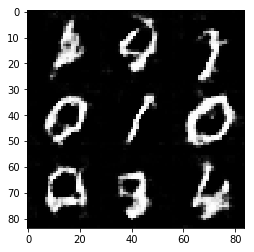

Epoch 1/2... Step 710... Discriminator Loss: 1.1925... Generator Loss: 0.8136
Epoch 1/2... Step 720... Discriminator Loss: 1.1606... Generator Loss: 1.0810
Epoch 1/2... Step 730... Discriminator Loss: 1.1018... Generator Loss: 1.0004
Epoch 1/2... Step 740... Discriminator Loss: 1.1694... Generator Loss: 0.8560
Epoch 1/2... Step 750... Discriminator Loss: 1.1397... Generator Loss: 0.8506
Epoch 1/2... Step 760... Discriminator Loss: 1.1955... Generator Loss: 0.8943
Epoch 1/2... Step 770... Discriminator Loss: 1.0863... Generator Loss: 1.0522
Epoch 1/2... Step 780... Discriminator Loss: 1.2160... Generator Loss: 0.6743
Epoch 1/2... Step 790... Discriminator Loss: 1.1729... Generator Loss: 1.3860
Epoch 1/2... Step 800... Discriminator Loss: 1.1466... Generator Loss: 1.4380
Sample Outputs....


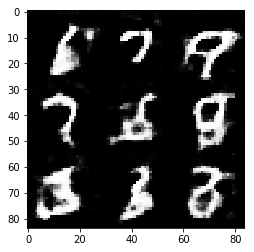

Epoch 1/2... Step 810... Discriminator Loss: 1.1148... Generator Loss: 0.9998
Epoch 1/2... Step 820... Discriminator Loss: 1.1887... Generator Loss: 1.4047
Epoch 1/2... Step 830... Discriminator Loss: 1.1185... Generator Loss: 1.2905
Epoch 1/2... Step 840... Discriminator Loss: 1.1540... Generator Loss: 0.8581
Epoch 1/2... Step 850... Discriminator Loss: 1.1892... Generator Loss: 0.8696
Epoch 1/2... Step 860... Discriminator Loss: 1.1128... Generator Loss: 0.9895
Epoch 1/2... Step 870... Discriminator Loss: 1.2000... Generator Loss: 1.3637
Epoch 1/2... Step 880... Discriminator Loss: 1.1107... Generator Loss: 1.1208
Epoch 1/2... Step 890... Discriminator Loss: 1.2065... Generator Loss: 1.1456
Epoch 1/2... Step 900... Discriminator Loss: 1.0958... Generator Loss: 1.0805
Sample Outputs....


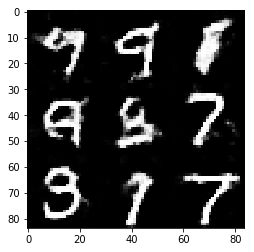

Epoch 1/2... Step 910... Discriminator Loss: 1.1373... Generator Loss: 1.1376
Epoch 1/2... Step 920... Discriminator Loss: 1.1001... Generator Loss: 0.9711
Epoch 1/2... Step 930... Discriminator Loss: 1.1886... Generator Loss: 0.8896
Epoch 2/2... Step 940... Discriminator Loss: 1.0836... Generator Loss: 1.0458
Epoch 2/2... Step 950... Discriminator Loss: 1.2778... Generator Loss: 0.6749
Epoch 2/2... Step 960... Discriminator Loss: 1.1304... Generator Loss: 0.8234
Epoch 2/2... Step 970... Discriminator Loss: 1.1312... Generator Loss: 0.9033
Epoch 2/2... Step 980... Discriminator Loss: 1.1881... Generator Loss: 1.4822
Epoch 2/2... Step 990... Discriminator Loss: 1.1023... Generator Loss: 1.1693
Epoch 2/2... Step 1000... Discriminator Loss: 1.1518... Generator Loss: 0.8742
Sample Outputs....


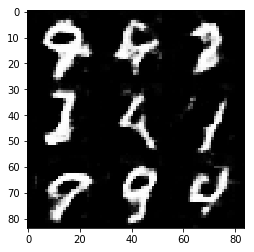

Epoch 2/2... Step 1010... Discriminator Loss: 1.1090... Generator Loss: 1.2149
Epoch 2/2... Step 1020... Discriminator Loss: 1.1128... Generator Loss: 1.0441
Epoch 2/2... Step 1030... Discriminator Loss: 1.1774... Generator Loss: 1.2991
Epoch 2/2... Step 1040... Discriminator Loss: 1.1601... Generator Loss: 1.0458
Epoch 2/2... Step 1050... Discriminator Loss: 1.1381... Generator Loss: 0.7897
Epoch 2/2... Step 1060... Discriminator Loss: 1.1517... Generator Loss: 1.1037
Epoch 2/2... Step 1070... Discriminator Loss: 1.1941... Generator Loss: 0.7661
Epoch 2/2... Step 1080... Discriminator Loss: 1.1287... Generator Loss: 1.3347
Epoch 2/2... Step 1090... Discriminator Loss: 1.1211... Generator Loss: 1.2198
Epoch 2/2... Step 1100... Discriminator Loss: 1.1444... Generator Loss: 1.2552
Sample Outputs....


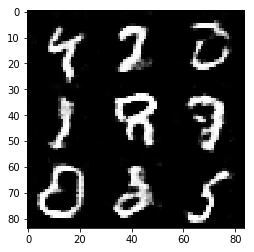

Epoch 2/2... Step 1110... Discriminator Loss: 1.2214... Generator Loss: 1.2084
Epoch 2/2... Step 1120... Discriminator Loss: 1.1670... Generator Loss: 1.2245
Epoch 2/2... Step 1130... Discriminator Loss: 1.1464... Generator Loss: 1.2085
Epoch 2/2... Step 1140... Discriminator Loss: 1.1845... Generator Loss: 0.8429
Epoch 2/2... Step 1150... Discriminator Loss: 1.1350... Generator Loss: 0.8598
Epoch 2/2... Step 1160... Discriminator Loss: 1.1698... Generator Loss: 0.8294
Epoch 2/2... Step 1170... Discriminator Loss: 1.2368... Generator Loss: 1.1910
Epoch 2/2... Step 1180... Discriminator Loss: 1.1618... Generator Loss: 0.7959
Epoch 2/2... Step 1190... Discriminator Loss: 1.1519... Generator Loss: 0.9102
Epoch 2/2... Step 1200... Discriminator Loss: 1.1336... Generator Loss: 0.8801
Sample Outputs....


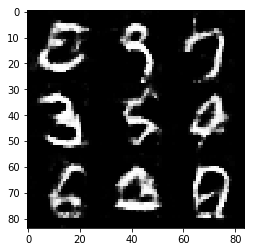

Epoch 2/2... Step 1210... Discriminator Loss: 1.1255... Generator Loss: 0.9832
Epoch 2/2... Step 1220... Discriminator Loss: 1.1038... Generator Loss: 1.0625
Epoch 2/2... Step 1230... Discriminator Loss: 1.1896... Generator Loss: 0.7513
Epoch 2/2... Step 1240... Discriminator Loss: 1.1321... Generator Loss: 1.0289
Epoch 2/2... Step 1250... Discriminator Loss: 1.2357... Generator Loss: 1.4026
Epoch 2/2... Step 1260... Discriminator Loss: 1.1794... Generator Loss: 1.0171
Epoch 2/2... Step 1270... Discriminator Loss: 1.1847... Generator Loss: 1.5482
Epoch 2/2... Step 1280... Discriminator Loss: 1.0497... Generator Loss: 1.0542
Epoch 2/2... Step 1290... Discriminator Loss: 1.0739... Generator Loss: 1.4472
Epoch 2/2... Step 1300... Discriminator Loss: 1.1106... Generator Loss: 1.1661
Sample Outputs....


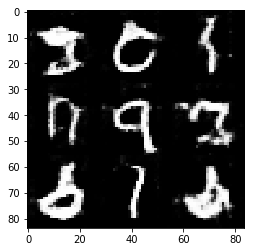

Epoch 2/2... Step 1310... Discriminator Loss: 1.1219... Generator Loss: 1.6179
Epoch 2/2... Step 1320... Discriminator Loss: 1.1601... Generator Loss: 0.7730
Epoch 2/2... Step 1330... Discriminator Loss: 1.1128... Generator Loss: 1.0428
Epoch 2/2... Step 1340... Discriminator Loss: 1.1342... Generator Loss: 1.0369
Epoch 2/2... Step 1350... Discriminator Loss: 1.2109... Generator Loss: 1.3697
Epoch 2/2... Step 1360... Discriminator Loss: 1.0945... Generator Loss: 1.1779
Epoch 2/2... Step 1370... Discriminator Loss: 1.1312... Generator Loss: 1.0199
Epoch 2/2... Step 1380... Discriminator Loss: 1.1064... Generator Loss: 1.2298
Epoch 2/2... Step 1390... Discriminator Loss: 1.1547... Generator Loss: 1.0964
Epoch 2/2... Step 1400... Discriminator Loss: 1.1331... Generator Loss: 1.2486
Sample Outputs....


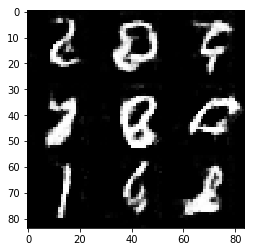

Epoch 2/2... Step 1410... Discriminator Loss: 1.1517... Generator Loss: 1.0096
Epoch 2/2... Step 1420... Discriminator Loss: 1.1362... Generator Loss: 1.3854
Epoch 2/2... Step 1430... Discriminator Loss: 1.0670... Generator Loss: 1.0037
Epoch 2/2... Step 1440... Discriminator Loss: 1.1133... Generator Loss: 1.1543
Epoch 2/2... Step 1450... Discriminator Loss: 1.1761... Generator Loss: 0.8757
Epoch 2/2... Step 1460... Discriminator Loss: 1.0549... Generator Loss: 1.0324
Epoch 2/2... Step 1470... Discriminator Loss: 1.1245... Generator Loss: 0.9293
Epoch 2/2... Step 1480... Discriminator Loss: 1.0818... Generator Loss: 0.8966
Epoch 2/2... Step 1490... Discriminator Loss: 1.0533... Generator Loss: 1.1043
Epoch 2/2... Step 1500... Discriminator Loss: 1.0617... Generator Loss: 1.0641
Sample Outputs....


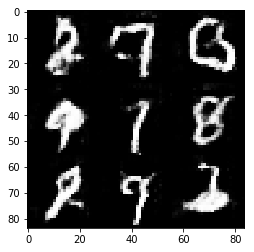

Epoch 2/2... Step 1510... Discriminator Loss: 1.1947... Generator Loss: 0.8382
Epoch 2/2... Step 1520... Discriminator Loss: 1.1624... Generator Loss: 0.8190
Epoch 2/2... Step 1530... Discriminator Loss: 1.0642... Generator Loss: 1.0466
Epoch 2/2... Step 1540... Discriminator Loss: 1.1496... Generator Loss: 1.4033
Epoch 2/2... Step 1550... Discriminator Loss: 1.2256... Generator Loss: 0.6590
Epoch 2/2... Step 1560... Discriminator Loss: 1.1119... Generator Loss: 1.1957
Epoch 2/2... Step 1570... Discriminator Loss: 1.1179... Generator Loss: 1.1071
Epoch 2/2... Step 1580... Discriminator Loss: 1.1622... Generator Loss: 1.3457
Epoch 2/2... Step 1590... Discriminator Loss: 1.0820... Generator Loss: 1.2384
Epoch 2/2... Step 1600... Discriminator Loss: 1.1658... Generator Loss: 0.7855
Sample Outputs....


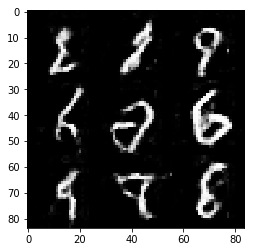

Epoch 2/2... Step 1610... Discriminator Loss: 1.1295... Generator Loss: 0.9007
Epoch 2/2... Step 1620... Discriminator Loss: 1.1528... Generator Loss: 1.3358
Epoch 2/2... Step 1630... Discriminator Loss: 1.0646... Generator Loss: 1.2341
Epoch 2/2... Step 1640... Discriminator Loss: 1.0850... Generator Loss: 0.9287
Epoch 2/2... Step 1650... Discriminator Loss: 1.0795... Generator Loss: 1.1660
Epoch 2/2... Step 1660... Discriminator Loss: 1.1033... Generator Loss: 1.0085
Epoch 2/2... Step 1670... Discriminator Loss: 1.1444... Generator Loss: 1.3590
Epoch 2/2... Step 1680... Discriminator Loss: 1.1174... Generator Loss: 1.4467
Epoch 2/2... Step 1690... Discriminator Loss: 1.1353... Generator Loss: 1.2299
Epoch 2/2... Step 1700... Discriminator Loss: 1.1228... Generator Loss: 1.0121
Sample Outputs....


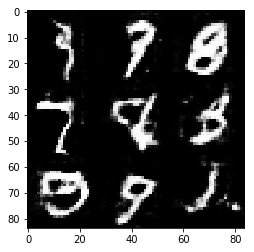

Epoch 2/2... Step 1710... Discriminator Loss: 1.0801... Generator Loss: 1.4229
Epoch 2/2... Step 1720... Discriminator Loss: 1.1575... Generator Loss: 1.2883
Epoch 2/2... Step 1730... Discriminator Loss: 1.2191... Generator Loss: 0.7126
Epoch 2/2... Step 1740... Discriminator Loss: 1.2209... Generator Loss: 1.3053
Epoch 2/2... Step 1750... Discriminator Loss: 1.0374... Generator Loss: 1.0943
Epoch 2/2... Step 1760... Discriminator Loss: 1.0718... Generator Loss: 0.9683
Epoch 2/2... Step 1770... Discriminator Loss: 1.1110... Generator Loss: 1.2720
Epoch 2/2... Step 1780... Discriminator Loss: 1.0874... Generator Loss: 1.2417
Epoch 2/2... Step 1790... Discriminator Loss: 1.0828... Generator Loss: 1.0454
Epoch 2/2... Step 1800... Discriminator Loss: 1.1021... Generator Loss: 0.9607
Sample Outputs....


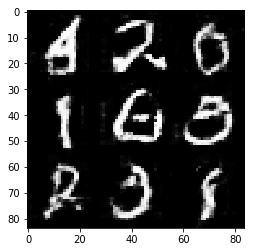

Epoch 2/2... Step 1810... Discriminator Loss: 1.0686... Generator Loss: 1.1151
Epoch 2/2... Step 1820... Discriminator Loss: 1.1764... Generator Loss: 0.7304
Epoch 2/2... Step 1830... Discriminator Loss: 1.1195... Generator Loss: 1.1418
Epoch 2/2... Step 1840... Discriminator Loss: 1.2059... Generator Loss: 1.4433
Epoch 2/2... Step 1850... Discriminator Loss: 1.2472... Generator Loss: 1.6062
Epoch 2/2... Step 1860... Discriminator Loss: 1.0839... Generator Loss: 1.1487
Epoch 2/2... Step 1870... Discriminator Loss: 1.1819... Generator Loss: 0.7557


In [33]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10... Discriminator Loss: 4.4048... Generator Loss: 0.0405
Epoch 1/1... Step 20... Discriminator Loss: 2.1786... Generator Loss: 0.3120
Epoch 1/1... Step 30... Discriminator Loss: 1.7324... Generator Loss: 0.7482
Epoch 1/1... Step 40... Discriminator Loss: 1.5418... Generator Loss: 0.9191
Epoch 1/1... Step 50... Discriminator Loss: 1.5013... Generator Loss: 0.8998
Epoch 1/1... Step 60... Discriminator Loss: 1.3539... Generator Loss: 1.0403
Epoch 1/1... Step 70... Discriminator Loss: 1.5436... Generator Loss: 0.8714
Epoch 1/1... Step 80... Discriminator Loss: 1.4921... Generator Loss: 0.8472
Epoch 1/1... Step 90... Discriminator Loss: 1.7471... Generator Loss: 0.7599
Epoch 1/1... Step 100... Discriminator Loss: 1.7277... Generator Loss: 0.7536
Sample Outputs....


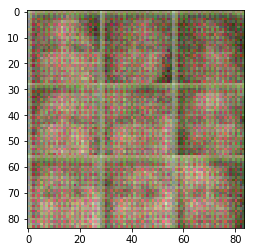

Epoch 1/1... Step 110... Discriminator Loss: 1.7889... Generator Loss: 0.6702
Epoch 1/1... Step 120... Discriminator Loss: 1.6339... Generator Loss: 0.8040
Epoch 1/1... Step 130... Discriminator Loss: 1.6088... Generator Loss: 0.7904
Epoch 1/1... Step 140... Discriminator Loss: 1.7772... Generator Loss: 0.7066
Epoch 1/1... Step 150... Discriminator Loss: 1.5059... Generator Loss: 0.7971
Epoch 1/1... Step 160... Discriminator Loss: 1.6643... Generator Loss: 0.7366
Epoch 1/1... Step 170... Discriminator Loss: 1.5770... Generator Loss: 0.8089
Epoch 1/1... Step 180... Discriminator Loss: 1.6739... Generator Loss: 0.6912
Epoch 1/1... Step 190... Discriminator Loss: 1.6530... Generator Loss: 0.7330
Epoch 1/1... Step 200... Discriminator Loss: 1.6276... Generator Loss: 0.7204
Sample Outputs....


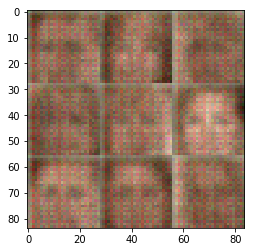

Epoch 1/1... Step 210... Discriminator Loss: 1.7295... Generator Loss: 0.6623
Epoch 1/1... Step 220... Discriminator Loss: 1.6158... Generator Loss: 0.6706
Epoch 1/1... Step 230... Discriminator Loss: 1.5803... Generator Loss: 0.7138
Epoch 1/1... Step 240... Discriminator Loss: 1.5621... Generator Loss: 0.7254
Epoch 1/1... Step 250... Discriminator Loss: 1.5495... Generator Loss: 0.7010
Epoch 1/1... Step 260... Discriminator Loss: 1.5860... Generator Loss: 0.7125
Epoch 1/1... Step 270... Discriminator Loss: 1.5534... Generator Loss: 0.7203
Epoch 1/1... Step 280... Discriminator Loss: 1.5299... Generator Loss: 0.7581
Epoch 1/1... Step 290... Discriminator Loss: 1.4742... Generator Loss: 0.7742
Epoch 1/1... Step 300... Discriminator Loss: 1.5672... Generator Loss: 0.7071
Sample Outputs....


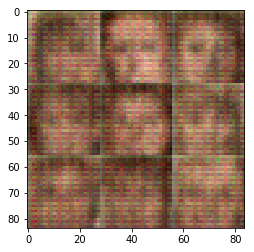

Epoch 1/1... Step 310... Discriminator Loss: 1.5092... Generator Loss: 0.7671
Epoch 1/1... Step 320... Discriminator Loss: 1.4809... Generator Loss: 0.8243
Epoch 1/1... Step 330... Discriminator Loss: 1.5239... Generator Loss: 0.7445
Epoch 1/1... Step 340... Discriminator Loss: 1.4648... Generator Loss: 0.7314
Epoch 1/1... Step 350... Discriminator Loss: 1.4821... Generator Loss: 0.7771
Epoch 1/1... Step 360... Discriminator Loss: 1.4479... Generator Loss: 0.7635
Epoch 1/1... Step 370... Discriminator Loss: 1.4854... Generator Loss: 0.7747
Epoch 1/1... Step 380... Discriminator Loss: 1.4460... Generator Loss: 0.7779
Epoch 1/1... Step 390... Discriminator Loss: 1.4204... Generator Loss: 0.7709
Epoch 1/1... Step 400... Discriminator Loss: 1.4492... Generator Loss: 0.7895
Sample Outputs....


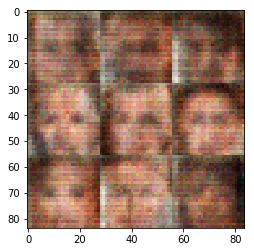

Epoch 1/1... Step 410... Discriminator Loss: 1.4333... Generator Loss: 0.7880
Epoch 1/1... Step 420... Discriminator Loss: 1.4419... Generator Loss: 0.7803
Epoch 1/1... Step 430... Discriminator Loss: 1.4312... Generator Loss: 0.7974
Epoch 1/1... Step 440... Discriminator Loss: 1.4203... Generator Loss: 0.7830
Epoch 1/1... Step 450... Discriminator Loss: 1.4137... Generator Loss: 0.7979
Epoch 1/1... Step 460... Discriminator Loss: 1.3908... Generator Loss: 0.8096
Epoch 1/1... Step 470... Discriminator Loss: 1.4379... Generator Loss: 0.8151
Epoch 1/1... Step 480... Discriminator Loss: 1.3887... Generator Loss: 0.8143
Epoch 1/1... Step 490... Discriminator Loss: 1.3852... Generator Loss: 0.7921
Epoch 1/1... Step 500... Discriminator Loss: 1.3974... Generator Loss: 0.7833
Sample Outputs....


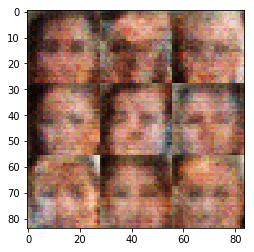

Epoch 1/1... Step 510... Discriminator Loss: 1.3032... Generator Loss: 0.9253
Epoch 1/1... Step 520... Discriminator Loss: 1.3802... Generator Loss: 0.8249
Epoch 1/1... Step 530... Discriminator Loss: 1.3898... Generator Loss: 0.8445
Epoch 1/1... Step 540... Discriminator Loss: 1.3432... Generator Loss: 0.8471
Epoch 1/1... Step 550... Discriminator Loss: 1.3924... Generator Loss: 0.7851
Epoch 1/1... Step 560... Discriminator Loss: 1.2867... Generator Loss: 0.8924
Epoch 1/1... Step 570... Discriminator Loss: 1.3072... Generator Loss: 0.8810
Epoch 1/1... Step 580... Discriminator Loss: 1.2360... Generator Loss: 0.8569
Epoch 1/1... Step 590... Discriminator Loss: 1.2460... Generator Loss: 0.9310
Epoch 1/1... Step 600... Discriminator Loss: 1.2441... Generator Loss: 0.9280
Sample Outputs....


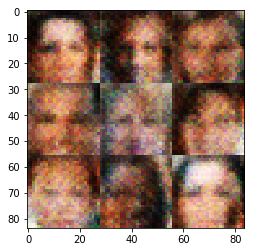

Epoch 1/1... Step 610... Discriminator Loss: 1.2239... Generator Loss: 1.0356
Epoch 1/1... Step 620... Discriminator Loss: 1.1487... Generator Loss: 1.0534
Epoch 1/1... Step 630... Discriminator Loss: 1.1672... Generator Loss: 1.1494
Epoch 1/1... Step 640... Discriminator Loss: 1.1282... Generator Loss: 0.8401
Epoch 1/1... Step 650... Discriminator Loss: 1.0536... Generator Loss: 1.1850
Epoch 1/1... Step 660... Discriminator Loss: 1.3047... Generator Loss: 1.5478
Epoch 1/1... Step 670... Discriminator Loss: 1.1040... Generator Loss: 0.9531
Epoch 1/1... Step 680... Discriminator Loss: 1.0049... Generator Loss: 1.1465
Epoch 1/1... Step 690... Discriminator Loss: 0.9193... Generator Loss: 1.1632
Epoch 1/1... Step 700... Discriminator Loss: 1.2846... Generator Loss: 1.3556
Sample Outputs....


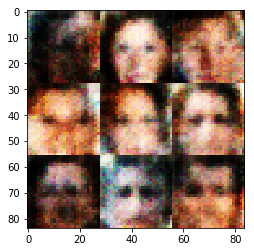

Epoch 1/1... Step 710... Discriminator Loss: 0.8992... Generator Loss: 1.1414
Epoch 1/1... Step 720... Discriminator Loss: 1.0391... Generator Loss: 1.3016
Epoch 1/1... Step 730... Discriminator Loss: 1.1570... Generator Loss: 1.3203
Epoch 1/1... Step 740... Discriminator Loss: 1.2686... Generator Loss: 1.6041
Epoch 1/1... Step 750... Discriminator Loss: 1.0795... Generator Loss: 1.2742
Epoch 1/1... Step 760... Discriminator Loss: 1.0961... Generator Loss: 1.0924
Epoch 1/1... Step 770... Discriminator Loss: 0.9138... Generator Loss: 1.3483
Epoch 1/1... Step 780... Discriminator Loss: 1.1385... Generator Loss: 1.3027
Epoch 1/1... Step 790... Discriminator Loss: 0.9890... Generator Loss: 0.9194
Epoch 1/1... Step 800... Discriminator Loss: 0.9233... Generator Loss: 1.2052
Sample Outputs....


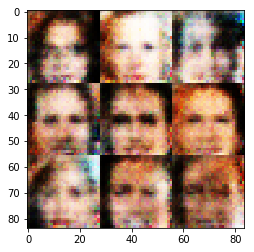

Epoch 1/1... Step 810... Discriminator Loss: 1.2289... Generator Loss: 1.0099
Epoch 1/1... Step 820... Discriminator Loss: 1.3418... Generator Loss: 0.9534
Epoch 1/1... Step 830... Discriminator Loss: 1.0805... Generator Loss: 1.1055
Epoch 1/1... Step 840... Discriminator Loss: 1.3123... Generator Loss: 0.9208
Epoch 1/1... Step 850... Discriminator Loss: 1.1707... Generator Loss: 0.9754
Epoch 1/1... Step 860... Discriminator Loss: 1.2047... Generator Loss: 0.9090
Epoch 1/1... Step 870... Discriminator Loss: 1.1894... Generator Loss: 0.9631
Epoch 1/1... Step 880... Discriminator Loss: 1.3063... Generator Loss: 0.9104
Epoch 1/1... Step 890... Discriminator Loss: 1.2409... Generator Loss: 0.8482
Epoch 1/1... Step 900... Discriminator Loss: 1.2626... Generator Loss: 0.8645
Sample Outputs....


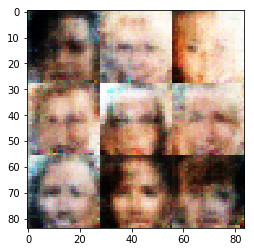

Epoch 1/1... Step 910... Discriminator Loss: 1.2494... Generator Loss: 0.9124
Epoch 1/1... Step 920... Discriminator Loss: 1.1969... Generator Loss: 0.9281
Epoch 1/1... Step 930... Discriminator Loss: 1.4085... Generator Loss: 0.9780
Epoch 1/1... Step 940... Discriminator Loss: 1.3042... Generator Loss: 0.8013
Epoch 1/1... Step 950... Discriminator Loss: 1.4378... Generator Loss: 0.7037
Epoch 1/1... Step 960... Discriminator Loss: 1.2584... Generator Loss: 0.8916
Epoch 1/1... Step 970... Discriminator Loss: 1.2946... Generator Loss: 0.8604
Epoch 1/1... Step 980... Discriminator Loss: 1.3504... Generator Loss: 0.8635
Epoch 1/1... Step 990... Discriminator Loss: 1.4177... Generator Loss: 0.7945
Epoch 1/1... Step 1000... Discriminator Loss: 1.3666... Generator Loss: 0.7961
Sample Outputs....


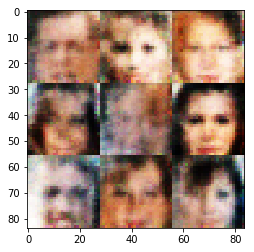

Epoch 1/1... Step 1010... Discriminator Loss: 1.4600... Generator Loss: 0.8259
Epoch 1/1... Step 1020... Discriminator Loss: 1.4627... Generator Loss: 0.7508
Epoch 1/1... Step 1030... Discriminator Loss: 1.4190... Generator Loss: 0.7748
Epoch 1/1... Step 1040... Discriminator Loss: 1.4598... Generator Loss: 0.8025
Epoch 1/1... Step 1050... Discriminator Loss: 1.4069... Generator Loss: 0.8066
Epoch 1/1... Step 1060... Discriminator Loss: 1.4231... Generator Loss: 0.8175


KeyboardInterrupt: 

In [34]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.